In [1]:
#@markdown ### **Imports**
# Torch and torchvision
from torchvision import models, datasets, transforms
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# other python things
import json, cv2, os, shutil, gdown, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import files

In [2]:
#@markdown ### **Installing pip packages**
#@markdown - Set up kaggle.json with key
! pip install -q kaggle

kaggle_json_path = "kaggle.json"
if not os.path.isfile(kaggle_json_path):
    url = "https://drive.google.com/file/d/1F_ioTSEkX2Nasm_QqH-zVjrJTI2GQiIW/view?usp=sharing"
    gdown.download(url, output=kaggle_json_path, fuzzy=True)

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets list

Downloading...
From: https://drive.google.com/uc?id=1F_ioTSEkX2Nasm_QqH-zVjrJTI2GQiIW
To: /content/kaggle.json
100%|██████████| 64.0/64.0 [00:00<00:00, 240kB/s]


In [3]:
# Down celeba-dataset as a zip file, then unzip
! kaggle datasets download -d jessicali9530/celeba-dataset
! unzip celeba-dataset.zip \
&> /dev/null # mute output

 99% 1.32G/1.33G [00:19<00:00, 70.4MB/s]
100% 1.33G/1.33G [00:19<00:00, 74.4MB/s]


In [4]:
#@markdown ### **Other relevant CelebA Files**
#@markdown
#@markdown Downloads `identity_CelebA.txt` and other required files.
#@markdown
#@markdown - `identity_CelebA.txt`: Pairs images with one of 10,177 identities
#@markdown - `list_eval_partition.csv`: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing.
#@markdown - `list_bbox_celeba.csv`: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box.
#@markdown - `list_landmarks_align_celeba.csv`: Image landmarks and their respective coordinates.
#@markdown  - There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
#@markdown - `list_attr_celeba.csv`: Attribute labels for each image.
#@markdown  - There are 40 attributes, with `1` representing positive and `-1` representing negative.

# Upload identity_CelebA.txt, additional required file
identity_path = '/content/identity_CelebA.txt'
if not os.path.isfile(identity_path):
    url = 'https://drive.google.com/file/d/1aRrdOyGOhf15CI8dI1yQDPlYJXGXNsTj/view?usp=sharing'
    gdown.download(url, output=identity_path, fuzzy=True)

# Read in identity data and split folders by it
identity_df = pd.read_csv(identity_path, sep=' ', header=None, names=['image_id', 'identity'])
num_identities = identity_df['identity'].nunique()
print("Total number of identities:", num_identities)

# 1. Split into train, validation, and test sets using list_eval_partition.csv
partitions_df = pd.read_csv('/content/list_eval_partition.csv', header=0, names=['image_id', 'partition'])

# Define paths
imgs_root_dir = '/content/img_align_celeba/img_align_celeba'
train_dir = '/content/img_align_celeba/train'
val_dir = '/content/img_align_celeba/validation'
test_dir = '/content/img_align_celeba/test'

# Ensure target directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move images to their respective set directories
def move_images(row):
    src = os.path.join(imgs_root_dir, row['image_id'])
    if os.path.exists(src):
        if row['partition'] == 0:
            dst = os.path.join(train_dir, row['image_id'])
        elif row['partition'] == 1:
            dst = os.path.join(val_dir, row['image_id'])
        else:
            dst = os.path.join(test_dir, row['image_id'])
        shutil.move(src, dst)

# Apply the function to each row in the DataFrame
partitions_df.apply(move_images, axis=1)

Downloading...
From: https://drive.google.com/uc?id=1aRrdOyGOhf15CI8dI1yQDPlYJXGXNsTj
To: /content/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 27.8MB/s]


Total number of identities: 10177


0         None
1         None
2         None
3         None
4         None
          ... 
202594    None
202595    None
202596    None
202597    None
202598    None
Length: 202599, dtype: object

In [5]:
# 2. Split data into classes

def split_by_identity(directory, identity_df):
    for index, row in identity_df.iterrows():
        src = os.path.join(directory, row['image_id'])

        if os.path.exists(src):    # don't create empty class directories
            identity_dir = os.path.join(directory, str(row['identity']))
            os.makedirs(identity_dir, exist_ok=True)

            dst = os.path.join(identity_dir, row['image_id'])
            shutil.move(src, dst)


# Organize images by identity within each set (identity_df loaded in the cell above)
split_by_identity(train_dir, identity_df)
split_by_identity(val_dir, identity_df)
split_by_identity(test_dir, identity_df)

In [6]:
# 3. Create ImageFolders for the data, augment only training, others normalize

BATCH_SIZE, CHANNELS, HEIGHT, WIDTH = 48, 3, 224, 224  # Example dimensions

augmented_transforms = transforms.Compose([
    transforms.Resize((HEIGHT, WIDTH)), # resize image to 224x224
    transforms.RandomHorizontalFlip(p=0.5), # randomly flip horizontally
    transforms.RandomAffine(degrees=20, shear=10),  # randomly rotate by 20 degrees and shear by 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

basic_transforms = transforms.Compose([
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Mean and STD of ImageNet
])

# Create ImageFolders for each
train_set = datasets.ImageFolder(root=train_dir, transform=augmented_transforms)
val_set = datasets.ImageFolder(root=val_dir, transform=basic_transforms)
test_set = datasets.ImageFolder(root=test_dir, transform=basic_transforms)

# Print number of identities in each
identity_counts = (len(train_set.classes), len(val_set.classes), len(test_set.classes))
print("Number of train identities:", identity_counts[0])
print("Number of val identities:", identity_counts[1])
print("Number of test identities:", identity_counts[2])
print("Total identities across train, val, test:", sum(identity_counts)) # Showing that the sets of identities are disjoint

Number of train identities: 8192
Number of val identities: 985
Number of test identities: 1000
Total identities across train, val, test: 10177


In [7]:
# Function to convert a tensor to a PIL image for visualization.
def imshow(tensor, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    tensor = tensor.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    ax.imshow(tensor)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    return ax

torch.Size([3, 224, 224]) <class 'torch.Tensor'>
Images are allclose?: False


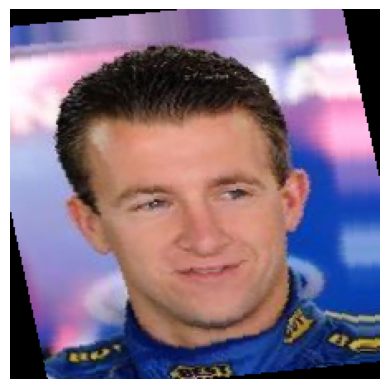

In [8]:
# Display an image from the training set
example_train_image = train_set[0][0]
print(example_train_image.shape, type(example_train_image)) # Shape shows 3 colour channels, and dimensions
imshow(example_train_image)

# Draw a second image from the training set, check similarity. Expecting False, as augmented.
example_train_image_2 = train_set[0][0]

print("Images are allclose?:", torch.allclose(example_train_image, example_train_image_2))

torch.Size([3, 224, 224]) <class 'torch.Tensor'>
Images are allclose?: True


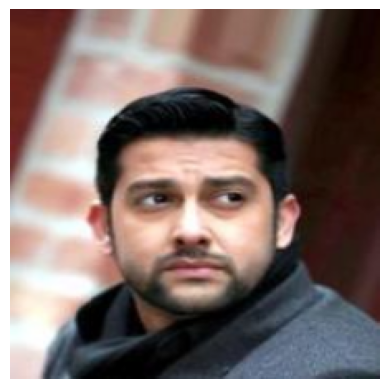

In [9]:
# Display an image from the validation set
example_val_image = val_set[0][0]
print(example_val_image.shape, type(example_val_image)) # Shape shows 3 colour channels, and dimensions
imshow(example_val_image)

# Draw a second image from the validation set, check similarity. Expecting False, as augmented.
example_val_image_2 = val_set[0][0]

print("Images are allclose?:", torch.allclose(example_val_image, example_val_image_2))

In [10]:
#@markdown ### **Loading Data into triples of (anchor, positive, negative)**
#@markdown - `anchor`: an image Tensor of shape `(3, 224, 224)`, of some identity.
#@markdown - `positive`: an image Tensor of shape `(3, 224, 224)`, of the same identity as `anchor`, but a different image.
#@markdown - `negative`: an image Tensor of shape `(3, 224, 224)`, of a different identity than both positive and anchor.

class TripletCelebADataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

        # Group indices by identity
        self.identity_to_indices = {}
        for idx, (_, identity) in enumerate(self.dataset.imgs):
            if identity not in self.identity_to_indices:
                self.identity_to_indices[identity] = [idx]
            else:
              self.identity_to_indices[identity].append(idx)

    def __getitem__(self, index):
        # Sample anchor from dataset
        anchor_idx = index
        anchor_img, anchor_identity = self.dataset[anchor_idx]

        # Sample positive example (same identity)
        positive_idxs = [idx for idx in self.identity_to_indices[anchor_identity] if idx != anchor_idx]
        if len(positive_idxs) == 0:
          positive_idx = anchor_idx
        else:
          positive_idx = random.choice(positive_idxs)
        positive_img, _ = self.dataset[positive_idx]

        # Sample negative example (different identity)
        negative_identity = random.choice([idt for idt in self.identity_to_indices.keys() if idt != anchor_identity])
        negative_idx = random.choice(self.identity_to_indices[negative_identity])
        negative_img, _ = self.dataset[negative_idx]

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.dataset)

# Create triples datasets for each of train, val, test
train_triples = TripletCelebADataset(train_set)
val_triples = TripletCelebADataset(val_set)
test_triples = TripletCelebADataset(test_set)

# Create dataloaders from these triples
train_loader = DataLoader(train_triples, batch_size=20, shuffle=True)
val_loader = DataLoader(val_triples, batch_size=20, shuffle=True)
test_loader = DataLoader(test_triples, batch_size=20, shuffle=True)

In [11]:
#@markdown ### **Displaying Triplets**
#@markdown
#@markdown Defines a function to show triplets.
#@markdown Code is collapsed for cleanliness' sake, but feel free to view using the `Show code` option below.

def imshow_triplets(tensors, titles=None, normalize=True):
    if titles is None: titles = ['Anchor', 'Positive', 'Negative']
    assert len(tensors) == len(titles)

    fig, axes = plt.subplots(1, len(titles), figsize=(15, 5))

    for ax, tensor, title in zip(axes, tensors, titles):
        # Check if tensor is a torch tensor and move it to numpy
        if tensor.requires_grad:  # Check if it's a PyTorch tensor that requires grad
            tensor = tensor.detach()  # Detach tensor from the graph
        tensor = tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy and adjust channel dimension

        # Normalize the image if required
        if normalize:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            tensor = std * tensor + mean  # Apply normalization

        # Clip values to ensure they are between 0 and 1
        tensor = np.clip(tensor, 0, 1)

        # Show the image
        ax.imshow(tensor)
        ax.set_title(title)
        ax.axis('off')  # Hide the axes ticks

    plt.show()

torch.Size([20, 3, 224, 224]) torch.Size([20, 3, 224, 224]) torch.Size([20, 3, 224, 224])


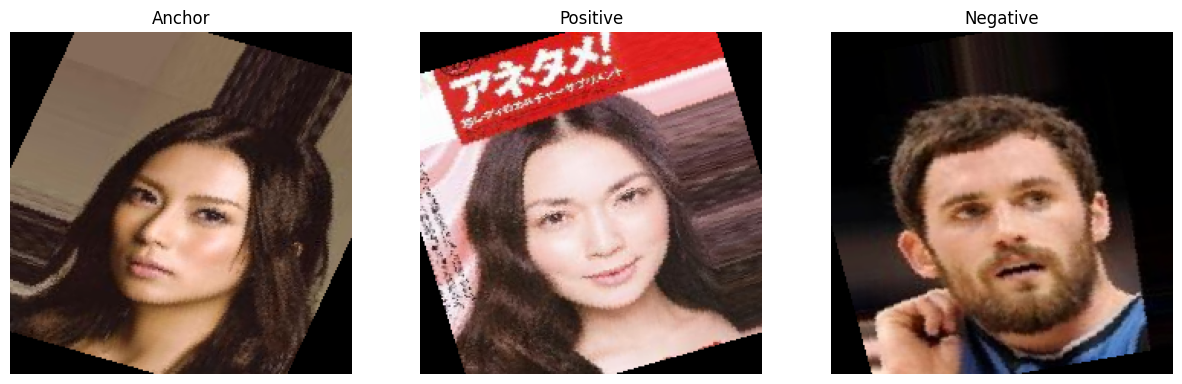

In [62]:
# Sampling a batch of 20 triplets triplet from the train dataloader:
example_anchors, example_positives, example_negatives = next(iter(train_loader))
print(example_anchors.shape, example_positives.shape, example_negatives.shape)

# Displaying the triple at index idx
example_idx = 5
imshow_triplets([example_anchors[example_idx], example_positives[example_idx], example_negatives[example_idx]])

### **Network**

Defines a custom ResNet50 architecture `ResNet50`, with pretrained weights from Torch.

In [29]:
class ResNet50(nn.Module):
    def __init__(self, input_size=224, emb_size=256):  # Default input size for ResNet is 224x224
        super(ResNet50, self).__init__()

        # Load pre-trained torch ResNet-50 model
        self.resnet50 = models.resnet50(weights='DEFAULT')

        self.features = nn.Sequential(*list(self.resnet50.children())[:-1])

        self.fc1 = nn.Linear(2048, emb_size)

    def forward(self, x):
        # Forward pass through the feature extractor
        x = self.features(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Forward pass through the custom classifier
        x = self.fc1(x)

        return x

In [23]:
#@markdown ### **Triplet Accuracy Function**

def get_accuracy(model, batch, device, verbose=False, extra_info=False):
    model.eval()
    correct, margin_correct, total = 0, 0, 0
    pos_stat, neg_stat = torch.zeros(2), torch.zeros(2)
    with torch.no_grad():
        # Compress data into a single big batch
        anchor, positive, negative = batch
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        # Get embeddings for each image in the triplet
        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)

        # Check output shape and adjust if necessary
        if len(anchor_output.shape) > 2:
            anchor_output = anchor_output.view(anchor_output.size(0), -1)  # Flatten if needed
            positive_output = positive_output.view(positive_output.size(0), -1)
            negative_output = negative_output.view(negative_output.size(0), -1)

        # Compute distances
        positive_distance = F.pairwise_distance(anchor_output, positive_output)
        negative_distance = F.pairwise_distance(anchor_output, negative_output)

        # Update distance totals
        pos_stat[0] = positive_distance.mean().item()
        pos_stat[1] = positive_distance.var().item()
        neg_stat[0] = negative_distance.mean().item()
        neg_stat[1] = negative_distance.var().item()

        # Determine if positive is closer to anchor than negative
        correct_distances_tensor = (positive_distance < negative_distance)
        correct_margin_tensor = (positive_distance < 1.0)
        correct = correct_distances_tensor.sum().item()
        margin_correct = correct_margin_tensor.sum().item()
        total = anchor.size(0)

    if verbose:
      print(f"Final Correct Rate: {correct}/{total}")
      print(f"Final Margin Correct Rate: {margin_correct}/{total}")

    accuracy = correct / total if total > 0 else 0
    if extra_info:
      margin_accuracy = margin_correct / total if total > 0 else 0
      return accuracy, margin_accuracy, pos_stat, neg_stat
    else:
      return accuracy

### **Siamese Triple Net Training**

Takes about an hour to train. If you don't want to wait, skip to the next cell to load pre-trained weights

In [33]:
# Siamese triple net training
def train_model(model,
                train_loader,
                valid_loader,
                batch_size=48,
                weight_decay=0.0,
                learning_rate=0.001,
                num_epochs=10,
                plot_every=50,
                margin=1.0,
                device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    model = model.to(device)
    criterion = nn.TripletMarginLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # print(f"train_data 1 tensor shape = {train_data[0].shape}")
    # print(f"valid_data 1 tensor shape = {valid_data[0].shape}")

    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0  # count the number of iterations that has passed
    val_iterator = iter(val_loader)
    try:
        for epoch in range(num_epochs):
            t = tqdm(train_loader, desc='Loss: N/A')
            for train_batch in t:
                # Send images to correct device
                anchor, positive, negative = train_batch
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                model.train()

                # Embed images using network, run loss and backprop
                anchor_emb, positive_emb, negative_emb = model(anchor), model(positive), model(negative)
                loss = criterion(anchor_emb, positive_emb, negative_emb)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    loss = float(loss)

                    t.set_description(f'Epoch: {epoch}, Loss: {loss}')
                    t.refresh()
                    tacc = get_accuracy(model, train_batch, device)
                    vacc = get_accuracy(model, next(val_iterator), device)
                    print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (iter_count, loss, tacc, vacc))

                    iters.append(iter_count)
                    train_loss.append(loss)
                    train_acc.append(tacc)
                    val_acc.append(vacc)
    finally:
        plt.figure()
        plt.plot(iters, train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.figure()
        plt.plot(iters, train_acc)
        plt.plot(iters, val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Validation"])


Loss: N/A:   0%|          | 0/8139 [00:00<?, ?it/s]

Iter 50; Loss 1.092082; Train Acc 0.900; Val Acc 0.850
Iter 100; Loss 0.486492; Train Acc 0.900; Val Acc 0.900
Iter 150; Loss 1.177810; Train Acc 0.700; Val Acc 0.650
Iter 200; Loss 0.878957; Train Acc 0.700; Val Acc 0.700
Iter 250; Loss 0.480355; Train Acc 0.950; Val Acc 0.800
Iter 300; Loss 0.676478; Train Acc 0.900; Val Acc 0.800
Iter 350; Loss 0.176792; Train Acc 1.000; Val Acc 0.750
Iter 400; Loss 0.679713; Train Acc 0.700; Val Acc 0.800
Iter 450; Loss 0.580317; Train Acc 0.850; Val Acc 0.950
Iter 500; Loss 0.542380; Train Acc 0.850; Val Acc 0.750
Iter 550; Loss 0.136267; Train Acc 0.950; Val Acc 0.850
Iter 600; Loss 0.443817; Train Acc 0.850; Val Acc 0.700
Iter 650; Loss 0.343360; Train Acc 0.950; Val Acc 0.750
Iter 700; Loss 0.527574; Train Acc 0.850; Val Acc 0.600
Iter 750; Loss 0.293791; Train Acc 0.850; Val Acc 0.950
Iter 800; Loss 0.364538; Train Acc 0.750; Val Acc 0.850
Iter 850; Loss 0.319048; Train Acc 0.900; Val Acc 0.950
Iter 900; Loss 0.291693; Train Acc 0.900; Val Acc

KeyboardInterrupt: 

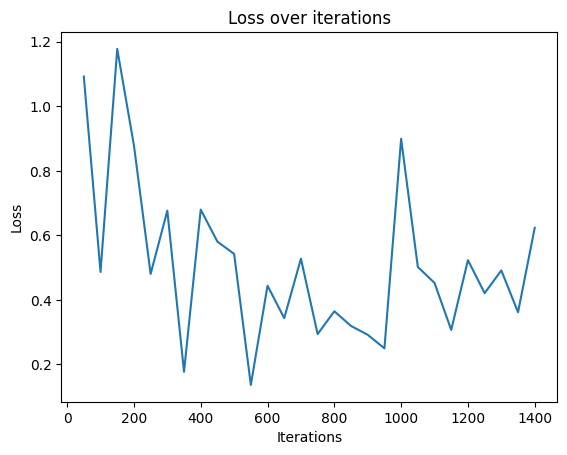

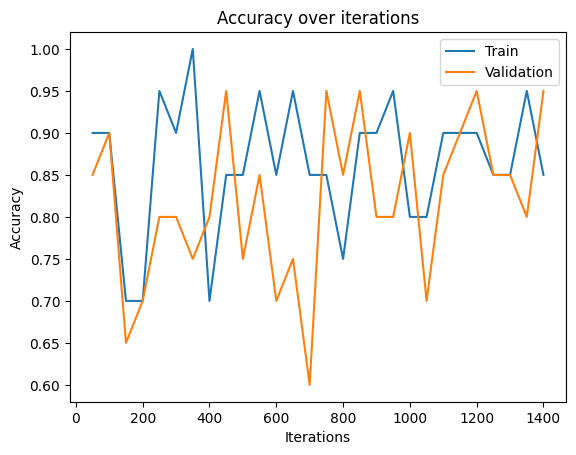

In [34]:
# Initialize an instance of the model
resnet = ResNet50()

# Train model for 100 epochs
train_model(resnet, train_loader, val_loader, num_epochs=100)

In [35]:
#@markdown ### **Saving Trained Checkpoint**
#@markdown Set `save_trained = True` to save trained weights.

save_trained = False
if save_trained:
    ckpt_path = 'model_1400.ckpt'
    torch.save(resnet.state_dict(), ckpt_path)
    print('Trained weights saved to {}.'.format(ckpt_path))
else:
    print("Skipped saving trained weights.")

Trained weights saved to model_1400.ckpt.


In [54]:
#@markdown ### **Loading Pretrained Checkpoint**
#@markdown Set `load_pretrained = True` to load pretrained weights.

load_pretrained = True
if load_pretrained:
  ckpt_path = 'model_1400.ckpt'
  if not os.path.isfile(ckpt_path):
      url = 'https://drive.google.com/file/d/15KMWaosma018umH1OgZmZ9ZJ8yovpYvN/view?usp=sharing'
      gdown.download(url, output=ckpt_path, quiet=False)
  state_dict = torch.load(ckpt_path, map_location='cuda')
  resnet = ResNet50()
  resnet.load_state_dict(state_dict)
  print('Pretrained weights loaded.')
else:
  print("Skipped pretrained weight loading.")

Pretrained weights loaded.


### **Predicting with the Model**
After training, we now have a model that outputs embeddings which are near for the same identity, and far for different identities. We can now devise a method to use this for inference. We'll consider the following in this colab:

- MLE Hypothesis testing, using positive and negative Gaussians computed using a validation set.

First, let's gather data on the mean and variance for the positive and negative cases over many different triplets. These can be used to compute a decision boundary, assuming the probability distributions over distance, $d$, are Gaussian:
$$
P(d|+) = \mathcal{N}(\mu_+, \sigma_+^2) \\
P(d|-) = \mathcal{N}(\mu_-, \sigma_-^2)
$$

The sample estimates for mean and variance are done below, alongside the MLE decision boundary calculation.

In [37]:
# Test on a subset of validation batches, checking the rate at which the positive class is nearer than the negative class
device = 'cuda'
val_iterator = iter(val_loader)
num_val = 200
avg_accuracy, avg_margin_accuracy, pos_mean, neg_mean = 0, 0, 0, 0
pos_var, neg_var = 0,0

for i in tqdm(range(num_val)):
  val_batch = next(val_iterator)
  if i == 0: batch_size = val_batch[0].shape[0]
  accuracy, margin_accuracy, pos_stat, neg_stat = get_accuracy(resnet, val_batch, device, extra_info=True)
  avg_accuracy += accuracy
  avg_margin_accuracy += margin_accuracy
  pos_mean += pos_stat[0]
  neg_mean += neg_stat[0]
  pos_var += pos_stat[1]
  neg_var += neg_stat[1]

avg_accuracy /= num_val
avg_margin_accuracy /= num_val
pos_mean /= num_val
neg_mean /= num_val
pos_var /= num_val
neg_var /= num_val
pos_stdev = torch.sqrt(pos_var)
neg_stdev = torch.sqrt(neg_var)
print(f'Data gathered for {num_val * batch_size} many triples from validation set:')
print(f'Positive < Negative occurs {avg_accuracy:.3f} of the time')
print(f'Positive < margin (1) occurs {avg_margin_accuracy:.3f} of the time')
print(f'Positive distance mean is {pos_mean:.3f}')
print(f'Negative distance mean is {neg_mean:.3f}')
print(f'Positive distance stdev is {pos_stdev:.3f}')
print(f'Negative distance stdev is {neg_stdev:.3f}')

  0%|          | 0/200 [00:00<?, ?it/s]

Data gathered for 4000 many triples from validation set:
Positive < Negative occurs 0.863 of the time
Positive < margin (1) occurs 0.017 of the time
Positive distance mean is 2.592
Negative distance mean is 4.779
Positive distance stdev is 0.979
Negative distance stdev is 1.726


In [39]:
#@markdown ### **Decision Boundary Calculation**

# Equation setup: ax^2 + bx + c = 0 form
a = 1/pos_stdev**2 - 1/neg_stdev**2
b = -2 * (pos_mean / pos_stdev**2 - neg_mean / neg_stdev**2)
c = (pos_mean**2 / pos_stdev**2 - neg_mean**2 / neg_stdev**2) - 2 * np.log(neg_stdev/pos_stdev)

# Solve the quadratic equation
x1, x2 = np.roots([a, b, c])

print(f"The decision boundary occurs at x1 = {x1:.2f} and x2 = {x2:.2f}")


The decision boundary occurs at x1 = 3.78 and x2 = -0.67


torch.Size([20, 3, 224, 224]) torch.Size([20, 3, 224, 224]) torch.Size([20, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Euclidean Distance: 3.1360971927642822
Images are similar.


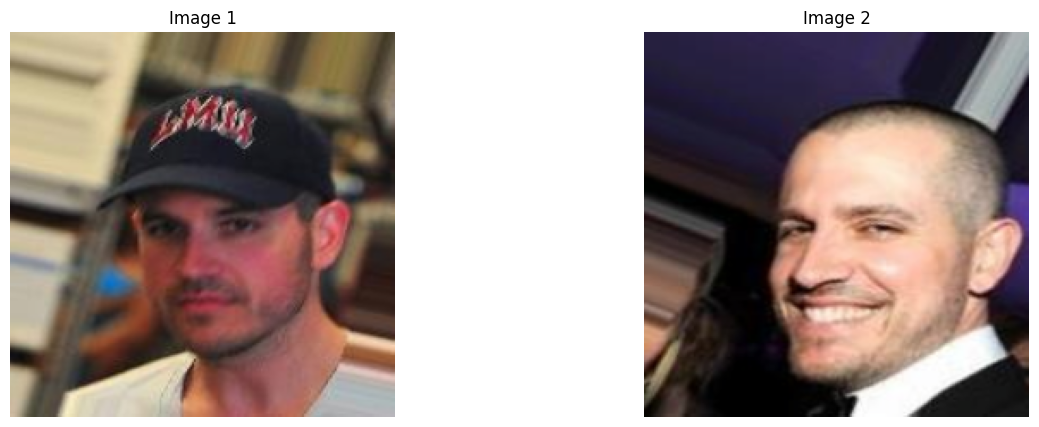

In [60]:
#@markdown ### **Predicting with the model**

from PIL import Image

# Load images
# Sampling a batch of 20 triplets triplet from the val dataloader:
example_anchors, example_positives, example_negatives = next(iter(val_loader))
print(example_anchors.shape, example_positives.shape, example_negatives.shape)

# Displaying the triple at index idx
example_idx = 5

img1_tensor = example_anchors[[example_idx]]
img2_tensor = example_positives[[example_idx]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)
resnet.eval()

# Move images to the correct device
img1_tensor = img1_tensor.to(device)
img2_tensor = img2_tensor.to(device)
print(img1_tensor.shape)

with torch.no_grad():
    # Get embeddings
    output1 = resnet(img1_tensor)
    output2 = resnet(img2_tensor)

    # Check if outputs need to be flattened
    if len(output1.shape) > 2:
        output1 = output1.view(output1.size(0), -1)
        output2 = output2.view(output2.size(0), -1)

    # Calculate Euclidean distance
    distance = F.pairwise_distance(output1, output2)

    # Print the distance
    print("Euclidean Distance:", distance.item())

    # Checking margin
    margin = 3.78
    if distance < margin:
        print("Images are similar.")
    else:
        print("Images are not similar.")

# Display images
imshow_triplets([img1_tensor[0], img2_tensor[0]], titles=['Image 1', 'Image 2'])

### **Create a Baseline CNN to compare the Siamese Triplet Model to:**

Prepare dataset:

In [53]:
train_set = datasets.ImageFolder(root=train_dir, transform=basic_transforms)
val_set = datasets.ImageFolder(root=val_dir, transform=basic_transforms)
test_set = datasets.ImageFolder(root=val_dir, transform=basic_transforms)

train_loader_CNN = DataLoader(train_set, batch_size=20, shuffle=True)
val_loader_CNN = DataLoader(val_set, batch_size=20, shuffle=True)
test_loader_CNN = DataLoader(test_set, batch_size=20, shuffle=True)

labels = np.array(train_set.classes + val_set.classes + test_set.classes)
labels[labels == ''] = 0.0
labels = labels.astype(int)
num_classes = max(labels)
print(num_classes)

10177


This lets us create a model that can try to predict an individual. But to create a direct comparison to the Siamese network we will begin by only comparing pairs of classes. We are doing this over having them both predict a model due to the numerical instability around 0% accuracy which occurs at 10000 celebrities.

In [ ]:
# Custom ResNet50 using torch resnet50 with pretrained weights
class ResNet50_CNN(nn.Module):
    def __init__(self, input_size=224, num_hidden_neurons=256, output_classes=500):  # Default input size for ResNet is 224x224
        super(ResNet50_CNN, self).__init__()

        # load pre-trained torch ResNet-50 model
        self.resnet50 = models.resnet50(pretrained=True)

        self.features = nn.Sequential(*list(self.resnet50.children())[:-1])

        self.classifier = nn.Sequential(
            nn.Linear(2048, num_hidden_neurons),
            nn.ReLU(),
        )

        self.embedding_to_classes = nn.Linear(num_hidden_neurons, output_classes)

    def forward(self, x):
        # Forward pass through the feature extractor
        x = self.features(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Forward pass through the custom classifier
        x = self.classifier(x)
        x = self.embedding_to_classes(x)

        return x

resnet_CNN = ResNet50_CNN(output_classes=num_classes)

In [ ]:
class TripletCelebADataset_But_only_Used_for_Standard_CNNs(Dataset):
    def __init__(self, dataset, augment=False):
        self.dataset = dataset
        self.augment = augment

        # define the augmented transform
        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=20, shear=10)
        ])

        # group indices by identity
        self.identity_to_indices = {}
        for idx, (_, identity) in enumerate(self.dataset.imgs):
            if identity not in self.identity_to_indices:
                self.identity_to_indices[identity] = []
            self.identity_to_indices[identity].append(idx)


    def __getitem__(self, index):
        anchor_idx = index
        anchor_img, anchor_identity = self.dataset[anchor_idx]

        # negative example (different identity), never do data augmentation in here
        negative_identity = random.choice([idt for idt in self.identity_to_indices.keys() if idt != anchor_identity])
        negative_idx = random.choice(self.identity_to_indices[negative_identity])

        return anchor_img, anchor_idx, negative_idx #positive_img, negative_img

    def __len__(self):
        return len(self.dataset)


train_triples = TripletCelebADataset_But_only_Used_for_Standard_CNNs(train_set)
val_triples = TripletCelebADataset_But_only_Used_for_Standard_CNNs(val_set)
test_triples = TripletCelebADataset_But_only_Used_for_Standard_CNNs(test_set)


train_loader = DataLoader(train_triples, batch_size=10, shuffle=True)
val_loader = DataLoader(val_triples, batch_size=10, shuffle=True)
test_loader = DataLoader(test_triples, batch_size=10, shuffle=True)

Create & configure the model:

In [ ]:
#@markdown ### **Accuracy and Training Loop for Baseline CNN**
#@markdown
#@markdown Hidden as it is large, press `Show code` to see if you'd like to.

def get_accuracy_CNN(model, sample, device, num_classes): # Work In Progress
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        input, labels = sample  # batched
        #print("LABELS:", labels)
        #print(labels.shape)
        input = input.to(device)
        labels = labels.to(device)
        sample_output = model(input)

        # Determine if positive is closer to anchor than negative
        incorrect_labels = np.random.randint(1, num_classes, size=20)
        incorrect_labels = torch.from_numpy(incorrect_labels).to(device)
        #print(type(labels))
        #print(type(incorrect_labels))
        #print(labels)
        #print(incorrect_labels)

        '''probability_of_correct_celebrity = sample_output[labels]
        probability_of_incorrect_celebrity = sample_output[incorrect_labels]'''

        probability_of_correct_celebrity = []
        probability_of_incorrect_celebrity = []
        for i in range(20):
          #individual_output = sample_output[i]
          #print(.shape)
          #print(labels[i])
          probability_of_correct_celebrity.append(sample_output[i][labels[i].item()].item())
          probability_of_incorrect_celebrity.append(sample_output[i][incorrect_labels[i].item()].item())

        #print(probability_of_correct_celebrity)
        #print(probability_of_incorrect_celebrity)
        #print(type(probability_of_correct_celebrity), type(probability_of_incorrect_celebrity))
        probability_of_correct_celebrity = np.array(probability_of_correct_celebrity)
        probability_of_incorrect_celebrity = np.array(probability_of_incorrect_celebrity)


        correct_predictions = probability_of_correct_celebrity > probability_of_incorrect_celebrity
        correct += correct_predictions.sum()
        total += len(input)

        ##print("current total Correct:", correct)
        ##print("current total Total:", total)

    if total > 0:
        return correct / total
    else:
        return 0

def train_model_CNN(model, train_loader, valid_loader,
                weight_decay=0.0,
                learning_rate=0.001,
                num_iters=10,
                plot_every=10,
                num_classes = 1000,
                device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []
    iter_count = 0  # count the number of iterations that has passed
    current_training_accuracy = 0
    current_validation_accuracy = 0
    current_loss = 0

    try:
        for epoch in range(num_iters):
            train_batch = next(iter(train_loader))    # get a single batch from train loader
            valid_batch = next(iter(valid_loader))    # get a single batch from valid loader

            training_inputs, training_labels = train_batch
            training_inputs = training_inputs.to(device)
            training_labels = training_labels.to(device)

            model.train()

            train_out = model.forward(training_inputs)
            #training_labels = F.one_hot(training_labels, )

            #print(type(train_out))
            #print(train_out.shape)
            #print(type(training_labels))
            #print(training_labels.shape)
            loss = criterion(train_out, training_labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #train_loss.append(loss.item())

            iter_count += 1
            current_loss += loss.item()

            if plot_every > 4:
              if iter_count % (plot_every // 4) == 0: # Do this more often (Note this errors)
                current_training_accuracy += get_accuracy_CNN(model, train_batch, device, num_classes) / 4
                current_validation_accuracy += get_accuracy_CNN(model, valid_batch, device, num_classes) / 4

            if iter_count % plot_every == 0:
                loss = current_loss / plot_every / len(training_inputs)
                iters.append(iter_count)
                tacc = current_training_accuracy
                vacc = current_validation_accuracy

                # This is expensive operation so I don't do it every time
                val_inputs, val_labels = valid_batch
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_out = model.forward(val_inputs)
                loss_val = (criterion(val_out, val_labels)).item() / len(val_inputs)

                print("Iter %d; Loss %f; Val Loss %f; Train Acc %.3f; Val Acc %.3f" % (iter_count, loss, loss_val, tacc, vacc))

                train_loss.append(loss)
                val_loss.append(loss_val)
                train_acc.append(tacc)
                val_acc.append(vacc)
                current_training_accuracy = 0
                current_validation_accuracy = 0
                current_loss = 0

    finally:
        plt.figure()
        # plt.plot(iters[:len(train_loss)], train_loss) # TODO: This keeps crashing for me so I wrote an alternate line, if it is only on my end you can continue using this
        plt.plot(iters, train_loss)
        plt.plot(iters, val_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend(["Train", "Validation"])

        plt.figure()
        # plt.plot(iters[:len(train_acc)], train_acc) # TODO: This keeps crashing for me so I wrote an alternate line, if it is only on my end you can continue using this
        plt.plot(iters, train_acc)
        # plt.plot(iters[:len(val_acc)], val_acc) # TODO: This keeps crashing for me so I wrote an alternate line, if it is only on my end you can continue using this
        plt.plot(iters, val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Validation"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# USING Triplet Data:
# Train for 16000 iterations
train_model_CNN(resnet_CNN, train_loader_CNN, val_loader_CNN, plot_every=10, num_classes=num_classes, num_iters=1000)
save_trained = True
if save_trained:
    ckpt_path = 'model_proper_80.ckpt'
    torch.save(resnet_CNN.state_dict(), ckpt_path)
    print('Trained weights saved to {}.'.format(ckpt_path))
else:
    print("Skipped saving trained weights.")

SyntaxError: invalid syntax (<ipython-input-24-fcb4b2e0a488>, line 17)

In [ ]:
train_model_CNN(resnet_CNN, train_loader_CNN, val_loader_CNN, plot_every=40, num_classes=num_classes, num_iters=3000)
save_trained = True
if save_trained:
    ckpt_path = 'model_proper_80.ckpt'
    torch.save(resnet_CNN.state_dict(), ckpt_path)
    print('Trained weights saved to {}.'.format(ckpt_path))
else:
    print("Skipped saving trained weights.")

In [ ]:
train_model_CNN(resnet_CNN, train_loader_CNN, val_loader_CNN, plot_every=10, num_classes=num_classes, num_iters=1000)
save_trained = True
if save_trained:
    ckpt_path = 'model_proper_80.ckpt'
    torch.save(resnet_CNN.state_dict(), ckpt_path)
    print('Trained weights saved to {}.'.format(ckpt_path))
else:
    print("Skipped saving trained weights.")

In [ ]:
train_model_CNN(resnet_CNN, train_loader_CNN, val_loader_CNN, plot_every=40, num_classes=num_classes, num_iters=3000)
save_trained = True
if save_trained:
    ckpt_path = 'model_proper_80.ckpt'
    torch.save(resnet_CNN.state_dict(), ckpt_path)
    print('Trained weights saved to {}.'.format(ckpt_path))
else:
    print("Skipped saving trained weights.")

In [ ]:
train_model_CNN(resnet_CNN, train_loader_CNN, val_loader_CNN, plot_every=40, num_classes=num_classes, num_iters=4000)
save_trained = True
if save_trained:
    ckpt_path = 'model_proper_12k.ckpt'
    torch.save(resnet_CNN.state_dict(), ckpt_path)
    print('Trained weights saved to {}.'.format(ckpt_path))
else:
    print("Skipped saving trained weights.")

In [ ]:
train_model_CNN(resnet_CNN, train_loader_CNN, val_loader_CNN, plot_every=40, num_classes=num_classes, num_iters=4000)
save_trained = True
if save_trained:
    ckpt_path = 'model_proper_16k.ckpt'
    torch.save(resnet_CNN.state_dict(), ckpt_path)
    print('Trained weights saved to {}.'.format(ckpt_path))
else:
    print("Skipped saving trained weights.")